# Fake News Detection 
## Group 2, Hollis Lab
### Members: Shuheng Liu, Qiaoyi Yin, Yuyuan  Fang
____

# Getting Set Up

### Infrastructure for embeddings

The following classes `DocumentSequence` and `DocumentEmbedder` can be found in tools.py. We encapsulated different ways of computing embeddings (doc2vec, naive doc2vec, one-hot) and their choices of hyperparameters in these files. Below is a snapshot of these classes their methods.
```python
class DocumentSequence:
    def __init__(self, raw_docs, clean=False, sw=None, punct=None): 
        
    def _set_tokenized(self, clean=False, sw=None, punct=None): 

    def _set_tagged(self): 

    def _set_dictionary(self):

    def _set_bow(self):

    def get_dictionary(self):

    def get_tokenized(self):

    def get_tagged(self):

    def get_bow(self):
```
        
```python

class DocumentEmbedder:
    def __init__(self, docs: DocumentSequence, pretrained_word2vec=None):

    def _set_word2vec(self):

    def _set_doc2vec(self, vector_size=300, window=5, min_count=5, dm=1, epochs=20):

    def _set_naive_doc2vec(self, normalizer='l2'):

    def _set_tfidf(self):

    def _set_onehot(self, scorer='tfidf'):

    def get_onehot(self, scorer='tfidf'):

    def get_doc2vec(self, vectors_size=300, window=5, min_count=5, dm=1, epochs=20):

    def get_naive_doc2vec(self, normalizer='l2'):

    def get_tfidf_score(self):
```


In [1]:
import pandas as pd
from string import punctuation
from nltk.corpus import stopwords

df = pd.read_csv("./fake_or_real_news.csv")

# obtain the raw news texts and titles
raw_text = df['text'].values
raw_title = df['title'].values
df['label'] = df['label'].apply(lambda label: 1 if label == "FAKE" else 0)

# build two instances for preprocessing raw data
from tools import DocumentSequence
texts = DocumentSequence(raw_text, clean=True, sw=stopwords.words('english'), punct=punctuation)
titles = DocumentSequence(raw_title, clean=True, sw=stopwords.words('english'), punct=punctuation)

df.head()

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/liushuheng/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     /Users/liushuheng/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liushuheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/liushuheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
converting raw docs into tokens
cleaning up stopwords and punctuations
all tokens to be skipped are: {'who', 'him', 'or', 'm', 'don', '#', '|', 'those', 'our', 'whom', '!', 'been', 'my', 'if', '(', '.', 'shan', "won't", 'o', "you'll", 'and', 'so', 'but', 're', 'this', 'not', '{', '-', '~', "that'll", 'now', 'll', "hadn't", 'she', 'just', 'his', 'no', 'hasn', 'from', 'do', 'did', 'you', "needn't", 'on', 'few', 'didn', 'an

,Unnamed: 0,title,text,label,title_vectors
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1,[ 1.1533764e-02 4.2144405e-03 1.9692603e-02 ...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,[ 0.11267698 0.02518966 -0.00212591 0.021095...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0,[ 0.04253004 0.04300297 0.01848392 0.048672...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,[ 0.10801624 0.11583211 0.02874823 0.061732...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0,[ 1.69016439e-02 7.13498285e-03 -7.81233795e-...


# Get embeddings
### Embeddings that we have:  (see README.md in our github repo)

| Embeddings | Parameters Tried| 
| ------ | ------ | 
| Dov2Vec | Min_count = 5/25/50| Win_size = 13/23| DBOW/DM | epochs=100/200/500|
| Naive D2V | Normalizer = L2/Mean/None | 
| One-Hot Sum |Rawcount/TF-IDF| Normalizer = L2/None | 
| Bigrams | TF-IDF |
| Attention is all you need | To be implemented |
| FastText | To be implemented |

## URL for different embeddings precomputed on cloud
- [all computed embeddings and labels](https://www.floydhub.com/wish1104/datasets/fake-news-embeddings/5), see list below
- [onehot title & text (sparse matrix)](https://www.floydhub.com/wish1104/projects/fake-news/33/output), scorer: 
raw-count
- [onehot title & text (sparse matrix)](https://www.floydhub.com/wish1104/projects/fake-news/35/output), scorer: 
raw-count, L2-normalized
- [onehot title & text (sparse matrix)](https://www.floydhub.com/wish1104/projects/fake-news/38/output), scorer: 
tfidf
- [onehot title & text (sparse matrix)](https://www.floydhub.com/wish1104/projects/fake-news/41/output), scorer: 
tfidf, L2-normalized
- [naive doc2vec title](https://www.floydhub.com/wish1104/projects/fake-news/19/output), normalizer: {L2, mean, None}
- [naive doc2vec text](https://www.floydhub.com/wish1104/projects/fake-news/20/output), normalizer: {L2, mean, None}
- [doc2vec title](https://www.floydhub.com/wish1104/projects/fake-news/21/output), window_size: 13, 
min_count:{5, 25, 50}, strategy: {DM, DBOW}, epochs: 100; all six combinations tried
- [doc2vec text](https://www.floydhub.com/wish1104/projects/fake-news/22/output), window_size: 13, 
min_count:{5, 25, 50}, strategy: {DM, DBOW}, epochs: 100; all six combinations tried
- [doc2vec title](https://www.floydhub.com/wish1104/projects/fake-news/88/output), window_size: {13, 23}, min_count: 5, 
strategy: DBOW, epochs: {200, 500}; all four combinations tried
- [doc2vec text](https://www.floydhub.com/wish1104/projects/fake-news/88/output), window_size: {13. 23}, min_count: 5, 
strategy: DBOW, epochs: {200, 500}; all four combinations tried

In [2]:
from tools import DocumentEmbedder

try:
    from embedding_loader import EmbeddingLoader

    loader = EmbeddingLoader("pretrained/")
    news_embeddings = loader.get_d2v("concat", vec_size=300, win_size=23, min_count=5, dm=0, epochs=500)
    labels = loader.get_label()

except FileNotFoundError as e:
    print(e)
    print("Cannot find existing embeddings, computing new ones now")

    pretrained = "./pretrained/GoogleNews-vectors-negative300.bin"
    text_embedder = DocumentEmbedder(texts, pretrained_word2vec=pretrained)
    title_embedder = DocumentEmbedder(titles, pretrained_word2vec=pretrained)

    text_embeddings = text_embedder.get_doc2vec(vectors_size=300, window=23, min_count=5, dm=0, epochs=500)
    title_embeddings = title_embedder.get_doc2vec(vectors_size=300, window=23, min_count=5, dm=0, epochs=500)
    
    # concatenate title vectors and text vectors
    news_embeddings = np.concatenate((title_embeddings, text_embeddings), axis=1)
    labels = df['label'].values


## Visualizing the embeddings

In [3]:
from embedding_visualizer import visualize_embeddings

# visualize the news embeddings in the graph
# MUST run in command line "tensorboard --logdir visual/" and visit localhost:6006 to see the visualization
visualize_embeddings(embedding_values=news_embeddings, label_values=labels, texts = raw_title)

Instructions for updating:
Use the retry module or similar alternatives.
currently setting metadata_path to metadata.tsv. Due to tensorboard version reasons, if prompted 'metadata not found' when visiting tensorboard server page, please manually edit metadata_path in projector_config.pbtxt to visual/metadata.tsv or the absolute path for `metadata.tsv` and restart tensorboard
If your tensorboard version is 1.7.0, you probably should not worry about this
Embeddings are available now. Please start your tensorboard server with commandline `tensorboard --logdir visual` and visit http://localhost:6006 to see the visualization


In [4]:
print("visit https://localhost:6006 to see the result")

# !tensorboard --logdir visual/ 
# ATTENTION: This cell must be manually stopped

visit https://localhost:6006 to see the result


Some screenshots of the tensorboard are shown below. We visuallize the embeddings of documents with T-SNE projection on 3D and 2D spaces. Each red data point indicates a piece of FAKE news, and each blue one indicates a piece of real news. These two categories are well-separated as can be seen from the visualization.

### 2D visualization (red for fake, blue for real)

![a](resources/T-SNE 2D.jpg)

### 3D visualization (red for fake, blue for real)

![a](resources/T-SNE 3D.jpg)

#### Visualizing bigram words statistics

In [5]:
import itertools
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

## Get tokenized words of fake news and real news independently
real_text = df[df['label'] == 0]['text'].values
fake_text = df[df['label'] == 1]['text'].values
sw = [word for word in stopwords.words("english")] + ["``", "“"]
other_puncts = u'.,;《》？！“”‘’@#￥%…&×（）——+【】{};；●，。&～、|\s:：````'
punct = punctuation + other_puncts
fake_words = DocumentSequence(real_text, clean=True, sw=sw, punct=punct)
real_words = DocumentSequence(fake_text, clean=True, sw=sw, punct=punct)

## Get cleaned text using chain
real_words_all = list(itertools.chain(*real_words.get_tokenized()))
fake_words_all = list(itertools.chain(*fake_words.get_tokenized()))

## Drawing histogram
def plot_most_common_words(num_to_show,words_list,title = ""):
    bigrams = nltk.bigrams(words_list)
    counter = Counter(bigrams)
    labels = [" ".join(e[0]) for e in counter.most_common(num_to_show)]
    values = [e[1] for e in counter.most_common(num_to_show)]

    indexes = np.arange(len(labels))
    width = 1
    
    plt.title(title)
    plt.barh(indexes, values, width)
    plt.yticks(indexes + width * 0.2, labels)
    plt.show()

converting raw docs into tokens
cleaning up stopwords and punctuations
all tokens to be skipped are: {'who', 'him', 'or', 'm', 'don', '#', '|', 'those', 'our', 'whom', '!', 'been', 'my', 'if', '(', '.', 'shan', "won't", '…', '）', 'o', "you'll", 'and', 'so', 'but', 're', 'this', '’', 'not', '{', '-', '（', '~', "that'll", 'now', 'll', "hadn't", 'she', 'just', '‘', 'his', 'no', 'hasn', 'from', 'do', 'did', 'you', "needn't", 'on', 'few', 'didn', 'any', '}', '》', 'before', 't', 'does', 'am', 'under', 'most', 'myself', 'them', 'for', 'than', 'her', '“', 'again', '\\', 'wasn', "weren't", 'which', 'more', 'doesn', '/', 'each', "should've", 'wouldn', "you'd", 'its', 'as', "isn't", "you've", '_', 'to', 'over', "she's", 'after', "shouldn't", '^', '&', '。', 'while', 'aren', 'can', "haven't", "didn't", '``', 'out', '@', 'that', '=', 'being', "doesn't", 'yours', '>', "it's", 'off', 'their', "couldn't", 'i', 'because', 'herself', 'down', 'above', 'own', 'haven', 'further', '%', 'nor', "you're", 'same

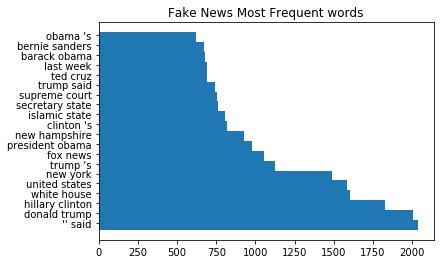

In [6]:
plot_most_common_words(20, fake_words_all, "Fake News Most Frequent words")

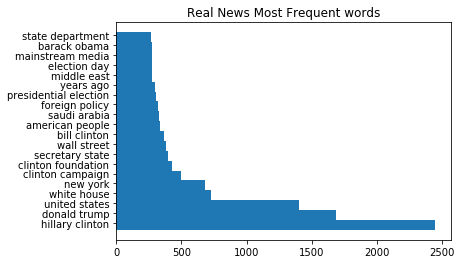

In [7]:
plot_most_common_words(20, real_words_all, "Real News Most Frequent words")

# Classification process

### For Doc2Vec:

#### Split the dataset (with 75% of data for 5-fold Randomsearching, 25% for testing)

In [8]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection._search import BaseSearchCV
import pickle as pkl

seed = 58

# perform the split which gets us the train data and the test data
news_train, news_test, labels_train, labels_test = train_test_split(news_embeddings, labels,
                                                                    test_size=0.25,
                                                                    random_state=seed,
                                                                    stratify=labels)

#### Classifier score and comparement 
We used RandomSearch on different datasets to get the best hyper-parameters.    
The following exhibits every classifier with almost optimal parameters in our experiments.   
The RandomSearch process is omitted.

In [9]:
import warnings
# Ignore some unimportant warnings
warnings.filterwarnings("ignore") 
                        
from mlxtend.classifier import EnsembleVoteClassifier

from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint
from scipy.stats.distributions import uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np

# MLP classifier
mlp = MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.8,
                    beta_2=0.9, early_stopping=False, epsilon=1e-08,
                    hidden_layer_sizes=(600, 300), learning_rate='constant',
                    learning_rate_init=0.0001, max_iter=500, momentum=0.9,
                    nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
                    solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
                    warm_start=False)

# KNN classifier
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
                           weights='distance')

# QDA classifier
qda = QuadraticDiscriminantAnalysis(priors=np.array([0.5, 0.5]),
                                    reg_param=0.6531083254653984, store_covariance=False,
                                    store_covariances=None, tol=0.0001)

# GDB classifier
gdb = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                 learning_rate=0.1, loss='exponential', max_depth=10,
                                 max_features='log2', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=0.0012436966435001434,
                                 min_samples_split=100, min_weight_fraction_leaf=0.0,
                                 n_estimators=200, presort='auto', random_state=0,
                                 subsample=0.8, verbose=0, warm_start=False)

# SVC classifier
svc = SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
          max_iter=-1, probability=True, random_state=0, shrinking=True,
          tol=0.001, verbose=False)

# GNB classifier
gnb = GaussianNB(priors=None)

# RF classifier
rf = RandomForestClassifier(bootstrap=False, class_weight=None,
                            criterion='entropy', max_depth=10, max_features=7,
                            max_leaf_nodes=None, min_impurity_decrease=0.0,
                            min_impurity_split=None, min_samples_leaf=9,
                            min_samples_split=6, min_weight_fraction_leaf=0.0,
                            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
                            verbose=0, warm_start=False)

# LG classifier
lg = LogisticRegression(C=7.374558791, class_weight=None, dual=False,
                        fit_intercept=True, intercept_scaling=1, max_iter=100,
                        multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                        solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

classifiers_list = [mlp, knn, qda, gdb, svc, gnb, rf, lg]

### Histogram of scores achieved by different classifiers
We list the best-performing hyperparameters in the following chart.

In [10]:
from sklearn.metrics import classification_report

# print details of testing results
for model in classifiers_list:
    model.fit(news_train, labels_train)
    labels_pred = model.predict(news_test)
    
    # Report the metrics
    target_names = ['Real', 'Fake']
    print(model.__class__.__name__)
    print(classification_report(y_true=labels_test, y_pred=labels_pred, target_names=target_names, digits=3))

MLPClassifier
             precision    recall  f1-score   support

       Real      0.956     0.950     0.953       793
       Fake      0.950     0.956     0.953       791

avg / total      0.953     0.953     0.953      1584

KNeighborsClassifier
             precision    recall  f1-score   support

       Real      0.849     0.905     0.876       793
       Fake      0.898     0.838     0.867       791

avg / total      0.874     0.872     0.872      1584

QuadraticDiscriminantAnalysis
             precision    recall  f1-score   support

       Real      0.784     0.995     0.877       793
       Fake      0.993     0.726     0.839       791

avg / total      0.889     0.860     0.858      1584

GradientBoostingClassifier
             precision    recall  f1-score   support

       Real      0.921     0.868     0.894       793
       Fake      0.875     0.925     0.899       791

avg / total      0.898     0.896     0.896      1584

SVC
             precision    recall  f1-score  

![a](resources/models_with_best_performance_updated2.jpg)

### Ensemble learning in the experiment
Besides, we used ensemble vote classifier to model the train data and try to obtain a better prediction from ensemble learning.

### For TF-IDF:
Getting sparse matrix

In [11]:
def bow2sparse(tfidf, corpus):
    rows = [index for index, line in enumerate(corpus) for _ in tfidf[line]]
    cols = [elem[0] for line in corpus for elem in tfidf[line]]
    data = [elem[1] for line in corpus for elem in tfidf[line]]
    return csr_matrix((data, (rows, cols)))

In [12]:
from gensim import corpora, models
from scipy.sparse import csr_matrix 

tfidf = models.TfidfModel(texts.get_bow())
tfidf_matrix = bow2sparse(tfidf, texts.get_bow())

## split the data
news_train, news_test, labels_train, labels_test = train_test_split(tfidf_matrix, 
                                                                    labels,
                                                                    test_size=0.25,
                                                                    random_state=seed)

dictionary is not set for <tools.DocumentSequence object at 0x11766bac8>, setting dictionary automatically


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# LogisticRegression
lg = LogisticRegression(C=104.31438384172546, penalty = 'l2')

# Naive Bayes
nb = MultinomialNB(alpha = 0.01977091215797838)

classifiers_list = [lg, nb]

from sklearn.metrics import classification_report

# print details of testing results
for model in classifiers_list:
    model.fit(news_train, labels_train)
    labels_pred = model.predict(news_test)
    
    # Report the metrics
    target_names = ['Real', 'Fake']
    print(str(model))
    print(classification_report(y_true=labels_test, y_pred=labels_pred, target_names=target_names, digits=3))

LogisticRegression(C=104.31438384172546, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

       Real      0.964     0.913     0.938       820
       Fake      0.912     0.963     0.937       764

avg / total      0.939     0.938     0.938      1584

MultinomialNB(alpha=0.01977091215797838, class_prior=None, fit_prior=True)
             precision    recall  f1-score   support

       Real      0.899     0.930     0.914       820
       Fake      0.922     0.887     0.905       764

avg / total      0.910     0.910     0.910      1584



#### Using coeffient to see what is important

In [14]:
# LogisticRegression
lg = LogisticRegression(C=104.31438384172546, penalty = 'l2')

# Using whole data set
lg.fit(tfidf_matrix, labels)

## map the coeffients with word and sort the coeffients
abs_features = []
num_features = tfidf_matrix.shape[0]
for i in range(num_features):
    coef = lg.coef_[0,i]
    abs_features.append(((coef), texts.get_dictionary()[i]))
        
sorted_result = sorted(abs_features, reverse = True)
fake_importance = [x for x in sorted_result if x[0] > 3]
real_importance = [x for x in sorted_result if x[0] < -4]

In [15]:
from wordcloud import WordCloud, STOPWORDS

def print_wordcloud(df, title=''):
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=1200, height=1000).generate(
        " ".join(df['word'].values))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')
    plt.show()

Words  with inclination to predict 'FAKE' news

In [16]:
df2 = pd.DataFrame(fake_importance, columns=['importance', 'word'])
df2.head(30)

,importance,word
0,13.781102,0
1,13.562957,2016
2,13.490582,october
3,13.062496,hillary
4,11.192181,‘
5,9.829864,article
6,9.411360,election
7,8.903777,november
8,8.181044,share
9,7.564924,print


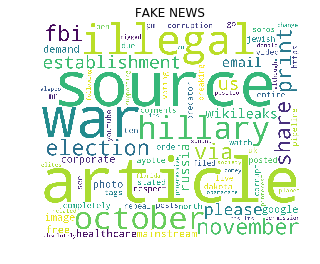

In [17]:
print_wordcloud(df2,'FAKE NEWS')

Words with inclination to predict 'REAL' news

In [18]:
df3 = pd.DataFrame(real_importance, columns=['importance', 'word'])
df3.tail(30)

,importance,word
48,-5.819761,march
49,-5.820939,state
50,-5.911077,attacks
51,-5.911102,deal
52,-5.918800,monday
53,-5.937717,saturday
54,-6.068661,president
55,-6.108548,conservatives
56,-6.197634,sanders
57,-6.316225,continue


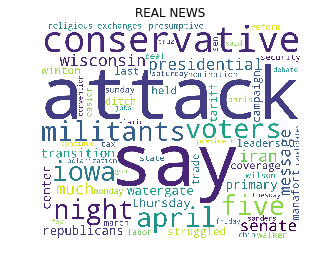

In [19]:
print_wordcloud(df3,'REAL NEWS')

### Ensemble learning in the experiment
Besides, we used ensemble vote classifier to model the train data and try to obtain a better prediction from ensemble learning.

![a](resources/Ensemble-Voter.png)

In [20]:
from model.ensemble_learning import EnsembleVoter

d2v_500 = loader.get_d2v(corpus="concat", win_size=23, epochs=500)
d2v_100 = loader.get_d2v(corpus="concat", win_size=13, epochs=100)
onehot = loader.get_onehot(corpus="concat", scorer="tfidf")
labels = loader.get_label()

d2v_500_train, d2v_500_test, d2v_100_train, d2v_100_test, onehot_train, onehot_test, labels_train, labels_test = \
    train_test_split(d2v_500, d2v_100, onehot, labels, test_size=0.25, stratify=labels, random_state=seed)

classifiers = [mlp, svc, qda, lg]
Xs_train = [d2v_500_train, d2v_100_train, d2v_100_train, onehot_train]
Xs_test = [d2v_500_test, d2v_100_test, d2v_100_test, onehot_test]

ens_voter = EnsembleVoter(classifiers, Xs_train, Xs_test, labels_train, labels_test)
ens_voter.fit()
print("Test score of EnsembleVoter: ", ens_voter.score())

Test score of MLPClassifier: 0.9526515151515151
Test score of SVC: 0.9425505050505051
Test score of QuadraticDiscriminantAnalysis: 0.9463383838383839
Test score of LogisticRegression: 0.9513888888888888
Fittng aborted because all voters are fitted and not using refit=True
Test score of EnsembleVoter:  0.963901203293
